# Event analysis
Investigate Asilomar small-scale array wave statistics from energetic storm event starting on July 13, 2022.

In [505]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
from tqdm.notebook import tqdm
# from mat73 import loadmat
from scipy.io import loadmat
from scipy import stats, signal
import cmocean
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import colors
from datetime import datetime as DT
from cftime import date2num, num2date
# Interactive plots
%matplotlib widget 

from roxsi_pyfuns import coordinate_transforms as rpct
from roxsi_pyfuns import wave_spectra as rpws
from roxsi_pyfuns import zero_crossings as rpzc
from roxsi_pyfuns import transfer_functions as rptf

# Paths
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray/'
mdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/mfiles'
data_root = os.path.join(rootdir, 'Signatures', 'Level1')
bathydir = os.path.join(rootdir, 'Bathy')
fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy.nc')
dsbat = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))

# Read API key from environment variable
api_key = os.environ["OPENAI_API_KEY"]

# Read large-scale array mooring locations table
fn_lsa = os.path.join(rootdir, 'ROXSI2022_LSA_mooring_locations.csv')
df_lsa = pd.read_csv(fn_lsa).set_index('Mooring')

# Sig100 serial number to visualize
# Choices: ['103088', '103094', '103110', '103063', '103206']
ser = 103094 #
veldir = os.path.join(data_root, '{}'.format(ser)) # Velocity netcdf directory
specdir = os.path.join(data_root, '{}'.format(ser), 'Spectra') # Spectra netcdf directory

# Nortek Vector ADVs
data_vec = os.path.join(rootdir, 'Vectors', 'Level1', 'netcdf_old')
fns_vec = sorted(glob.glob(os.path.join(data_vec, '*Vec*.nc')))

# Output figure directory
figdir  = os.path.join(rootdir, 'Vectors', 'Level1', 'img')
if not os.path.isdir(figdir):
    os.mkdir(figdir)

# Read Olavo's .mat file with Large-Scale Array mooring statistics
fn_nc_ss = os.path.join(rootdir, 'largescale_seaswell_hs.nc')
if not os.path.isfile(fn_nc_ss):
    fn_mat_times = os.path.join(mdir, 'seaswell_times.mat')
    times = loadmat(fn_mat_times)['times'].squeeze()
    # Convert time array to numerical format
    ref_date = pd.Timestamp('2022-06-01') # Reference date
    time_units = 'Seconds since {:%Y-%m-%d 00:00:00}'.format(ref_date)
    dfi = pd.DataFrame(data=np.zeros_like(times), index=pd.to_datetime(times))
    time_vals = date2num(dfi.index.to_pydatetime(), time_units, calendar='standard', 
        has_year_zero=True)
    # Mooring IDs
    fn_csv_mids = os.path.join(mdir, 'seaswell_mids.csv')
    mids = pd.read_csv(fn_csv_mids).keys().values.astype(str)
    # Hs for windsea
    fn_mat_hssea = os.path.join(mdir, 'seaswell_hs_sea.mat')
    hssea = loadmat(fn_mat_hssea)['hs_sea'].squeeze()
    # Hs for swell
    fn_mat_hsswell = os.path.join(mdir, 'seaswell_hs_swell.mat')
    hsswell = loadmat(fn_mat_hsswell)['hs_swell'].squeeze()
    # Hs for swell + sea
    fn_mat_hsseaswell = os.path.join(mdir, 'seaswell_hs_seaswell.mat')
    hsseaswell = loadmat(fn_mat_hsseaswell)['hs_seaswell'].squeeze()
    # fm for windsea
    fn_mat_fmsea = os.path.join(mdir, 'sea_fm.mat')
    fmsea = loadmat(fn_mat_fmsea)['fm_sea'].squeeze()
    # fm for swell
    fn_mat_fmswell = os.path.join(mdir, 'swell_fm.mat')
    fmswell = loadmat(fn_mat_fmswell)['fm_swell'].squeeze()
    # fm for swell + sea
    fn_mat_fmseaswell = os.path.join(mdir, 'seaswell_fm.mat')
    fmseaswell = loadmat(fn_mat_fmseaswell)['fm_seaswell'].squeeze()
    # Bottom depths
    fn_mat_depths = os.path.join(mdir, 'seaswell_depths.mat')
    depths = loadmat(fn_mat_depths)['depths'].squeeze()
    # Save as netcdf
    dss = xr.Dataset(
        data_vars=dict(
            hs_sea=(['time', 'mid'], hssea),
            hs_swell=(['time', 'mid'], hsswell),
            hs_seaswell=(['time', 'mid'], hsseaswell),
            fm_sea=(['time', 'mid'], fmsea),
            fm_swell=(['time', 'mid'], fmswell),
            fm_seaswell=(['time', 'mid'], fmseaswell),
            depth=(['time', 'mid'], depths),
        ),
        coords=dict(
            time=(['time'], time_vals),
            mid=(['mid'], mids),
        ),
        attrs=dict(description="Large-scale array sea/swell Hs."),
    )
    dss.time.encoding['units'] = time_units
    dss.time.attrs['units'] = time_units
    dss.time.attrs['standard_name'] = 'time'
    dss.time.attrs['long_name'] = 'Local time (PDT), midpoints of sampling intervals'
    # Set encoding before saving
    encoding = {'time': {'zlib': False, '_FillValue': None},
                'mid': {'zlib': False, '_FillValue': None},
                }
    # Set variable fill values
    fillvalue = -9999.
    for k in list(dss.keys()):
        encoding[k] = {'_FillValue': fillvalue}
    # Save to netCDF
    dss.to_netcdf(fn_nc_ss, encoding=encoding)
else:
    dss = xr.decode_cf(xr.open_dataset(fn_nc_ss, decode_coords='all'))


Plot time series of sea/swell Hs

Durations, E1: 1 days 00:00:00, E2: 1 days 00:00:00, E3: 1 days 00:00:00
Mean Hs ratios, E1: 1.53, E2: 11.64, E3: 3.36


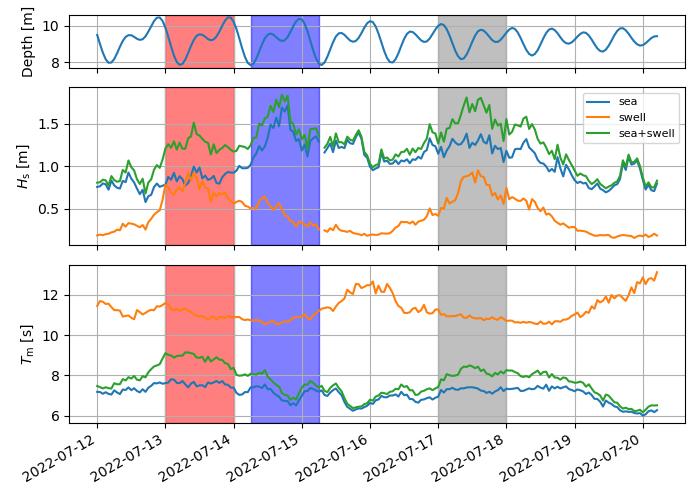

In [494]:
mid = 'X05'
# Crop plot to large wave event towards end of experiment
t0 = pd.Timestamp('2022-07-12 00:00:00')
t1 = pd.Timestamp('2022-07-21 00:00:00')
# Event start/end timestamps
t0_e1 = pd.Timestamp('2022-07-13 00:00:00')
t1_e1 = pd.Timestamp('2022-07-14 00:00:00')
t0_e2 = pd.Timestamp('2022-07-14 06:00:00')
t1_e2 = pd.Timestamp('2022-07-15 06:00:00')
t0_e3 = pd.Timestamp('2022-07-17 00:00:00')
t1_e3 = pd.Timestamp('2022-07-18 00:00:00')
edict = {'E1': [t0_e1, t1_e1], 'E2': [t0_e2, t1_e2], 'E3': [t0_e3, t1_e3], }
print('Durations, E1: {}, E2: {}, E3: {}'.format(t1_e1-t0_e1, t1_e2-t0_e2, t1_e3-t0_e3))
fig, axes = plt.subplots(figsize=(7,5), nrows=3, sharex=True, gridspec_kw={'height_ratios':[1,3,3]})
# Depth on top
dss.depth.sel(mid=mid, time=slice(t0, t1)).plot(ax=axes[0])
# Hs on 2nd row
# ax2 = axes[1].twinx()
dss.hs_sea.sel(mid=mid, time=slice(t0, t1)).plot(ax=axes[1], label='sea')
dss.hs_swell.sel(mid=mid, time=slice(t0, t1)).plot(ax=axes[1], label='swell')
dss.hs_seaswell.sel(mid=mid, time=slice(t0, t1)).plot(ax=axes[1], label='sea+swell')
# Tm on 3rd row
# ax2 = axes[1].twinx()
(1 / dss.fm_sea).sel(mid=mid, time=slice(t0, t1)).plot(ax=axes[2])
(1 / dss.fm_swell).sel(mid=mid, time=slice(t0, t1)).plot(ax=axes[2])
(1 / dss.fm_seaswell).sel(mid=mid, time=slice(t0, t1)).plot(ax=axes[2])
# (dss.hs_sea / dss.hs_swell).sel(mid=mid, time=slice(t0, t1)).plot(
#     ax=ax2, color='r', linestyle='--')
for ax in axes:
    ax.axvspan(t0_e1, t1_e1, alpha=0.5, color='r')
    ax.axvspan(t0_e2, t1_e2, alpha=0.5, color='b')
    ax.axvspan(t0_e3, t1_e3, alpha=0.5, color='gray')
    ax.grid()
    ax.set_title(None)
    ax.set_xlabel(None)
axes[0].set_ylabel(r'Depth [m]')
axes[1].set_ylabel(r'$H_\mathrm{s}$ [m]')
axes[2].set_ylabel(r'$T_\mathrm{m}$ [s]')
# ax2.set_ylabel(r'$H_\mathrm{s, sea} / H_\mathrm{s, swell}$ [m]')
axes[1].legend(fontsize=8)

# Print Hs ratios for each event
re1 = (dss.hs_sea**2 / dss.hs_swell**2).sel(mid=mid, time=slice(t0_e1, t1_e1)).mean().item()
re2 = (dss.hs_sea**2 / dss.hs_swell**2).sel(mid=mid, time=slice(t0_e2, t1_e2)).mean().item()
re3 = (dss.hs_sea**2 / dss.hs_swell**2).sel(mid=mid, time=slice(t0_e3, t1_e3)).mean().item()
print('Mean Hs ratios, E1: {:.2f}, E2: {:.2f}, E3: {:.2f}'.format(re1, re2, re3))

plt.tight_layout()
plt.show()

## Compute statistics for events

In [512]:
# Event start/end timestamps
t0_e1 = pd.Timestamp('2022-07-13 00:00:00')
t1_e1 = pd.Timestamp('2022-07-14 00:00:00')
t0_e2 = pd.Timestamp('2022-07-14 06:00:00')
t1_e2 = pd.Timestamp('2022-07-15 06:00:00')
t0_e3 = pd.Timestamp('2022-07-17 00:00:00')
t1_e3 = pd.Timestamp('2022-07-18 00:00:00')
edict = {'E1': [t0_e1, t1_e1], 'E2': [t0_e2, t1_e2], 'E3': [t0_e3, t1_e3], }

# Save spectra and angles for each event in dict
dsd = {'C2-E1': [], 'C2-E2': [], 'C2-E3': [], 
       'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
       'C4-E1': [], 'C4-E2': [], 'C4-E3': [], 
       'C5-E1': [], 'C5-E2': [], 'C5-E3': [], 
       'L2-E1': [], 'L2-E2': [], 'L2-E3': [], 
       'L4-E1': [], 'L4-E2': [], 'L4-E3': [], 
      }
# Heading, pitch & roll angles
dsa = {'C2-E1': [], 'C2-E2': [], 'C2-E3': [], 
       'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
       'C4-E1': [], 'C4-E2': [], 'C4-E3': [], 
       'C5-E1': [], 'C5-E2': [], 'C5-E3': [], 
       'L2-E1': [], 'L2-E2': [], 'L2-E3': [], 
       'L4-E1': [], 'L4-E2': [], 'L4-E3': [], 
      }
# 20-min mean Eastward velocities
uem = {'C2-E1': [], 'C2-E2': [], 'C2-E3': [], 
       'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
       'C4-E1': [], 'C4-E2': [], 'C4-E3': [], 
       'C5-E1': [], 'C5-E2': [], 'C5-E3': [], 
       'L2-E1': [], 'L2-E2': [], 'L2-E3': [], 
       'L4-E1': [], 'L4-E2': [], 'L4-E3': [], 
      }
# 20-min mean CS velocities
csm = {'C2-E1': [], 'C2-E2': [], 'C2-E3': [], 
       'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
       'C4-E1': [], 'C4-E2': [], 'C4-E3': [], 
       'C5-E1': [], 'C5-E2': [], 'C5-E3': [], 
       'L2-E1': [], 'L2-E2': [], 'L2-E3': [], 
       'L4-E1': [], 'L4-E2': [], 'L4-E3': [], 
      }
# 20-min mean Northward velocities
unm = {'C2-E1': [], 'C2-E2': [], 'C2-E3': [], 
       'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
       'C4-E1': [], 'C4-E2': [], 'C4-E3': [], 
       'C5-E1': [], 'C5-E2': [], 'C5-E3': [], 
       'L2-E1': [], 'L2-E2': [], 'L2-E3': [], 
       'L4-E1': [], 'L4-E2': [], 'L4-E3': [], 
      }
# 20-min mean LS velocities
lsm = {'C2-E1': [], 'C2-E2': [], 'C2-E3': [], 
       'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
       'C4-E1': [], 'C4-E2': [], 'C4-E3': [], 
       'C5-E1': [], 'C5-E2': [], 'C5-E3': [], 
       'L2-E1': [], 'L2-E2': [], 'L2-E3': [], 
       'L4-E1': [], 'L4-E2': [], 'L4-E3': [], 
      }
# 20-min mean vertical velocities
wm = {'C2-E1': [], 'C2-E2': [], 'C2-E3': [], 
      'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
      'C4-E1': [], 'C4-E2': [], 'C4-E3': [], 
      'C5-E1': [], 'C5-E2': [], 'C5-E3': [], 
      'L2-E1': [], 'L2-E2': [], 'L2-E3': [], 
      'L4-E1': [], 'L4-E2': [], 'L4-E3': [], 
     }
# 20-min mean sea level
slm = {'C2-E1': [], 'C2-E2': [], 'C2-E3': [], 
       'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
       'C4-E1': [], 'C4-E2': [], 'C4-E3': [], 
       'C5-E1': [], 'C5-E2': [], 'C5-E3': [], 
       'L2-E1': [], 'L2-E2': [], 'L2-E3': [], 
       'L4-E1': [], 'L4-E2': [], 'L4-E3': [], 
      }
# Bicoherence dataarrays
dsbc = {'C2-E1': [], 'C2-E2': [], 'C2-E3': [], 
        'C3-E1': [], 'C3-E2': [], 'C3-E3': [], 
        'C4-E1': [], 'C4-E2': [], 'C4-E3': [], 
        'C5-E1': [], 'C5-E2': [], 'C5-E3': [], 
        'L2-E1': [], 'L2-E2': [], 'L2-E3': [], 
        'L4-E1': [], 'L4-E2': [], 'L4-E3': [], 
       }
# Ratios of velocity spectra measured vs. linear theory from AST; only C3 for now
c3m0_um = {'E1': [], 'E2':[], 'E3':[]} # Hor. vel. m0, measured
c3m0_ul = {'E1': [], 'E2':[], 'E3':[]} # Hor. vel. m0, linear theory
c3m0_wm = {'E1': [], 'E2':[], 'E3':[]} # Ver. vel. m0, measured
c3m0_wl = {'E1': [], 'E2':[], 'E3':[]} # Ver. vel. m0, linear theory
# Zero-crossing stuff
dzcs = {}

cs = ['#CADBC0', '#C94277', '#A27E6F', '#94524A', '#2F0A28', '#6B717E']
servs = ['17212', '17219', '17371', '17372', '17376', '17377'] # Serial #s of Vectors
mids = ['C2', 'C3', 'C4', 'C5', 'L2', 'L4'] # Mooring IDs
# Iterate over event timestamps and compute statistics
for ki, k in enumerate(edict.keys()):
    t0e = edict[k][0]
    t1e = edict[k][1]
    print('E{}, t0: {}, t1: {}'.format(ki+1, t0e, t1e))
    # Read vector Level1 netcdf file for mooring C3
    vecd = {} # Dict to store Vector mean velocity datasets
    vecsd = {} # Dict to store Vector std velocity datasets
    dfd = {} # Dict to store (downward) zero-crossing dataframes
    for mid, serv in zip(mids, servs):
        dsl = [] # list for merging/averaging bicoherence dataarrays
        # print('Mooring ID: {}, serial no: {}'.format(mid, serv))
        # Get data dir of daily nc files
        ncdir = os.path.join(rootdir, 'Vectors', 'Level1', mid)
        # List all daily ncfiles
        fns_vec = sorted(glob.glob(os.path.join(ncdir, 'Asilomar_*.nc')))
        # Initialize lists to store zero-crossing data
        dzc = {'Hw': [], 'Hwn': [], 'Hc':[], 'Hcn':[], 'eta_mean':[], 'ucs_mean':[], 
               'uls_mean':[], 'w_mean':[], 'depth': [], 'Hwu': [], 'Hwun': [], 'Hcu': [], 'Hcun': [],} # DZC
        timestamps_d = []
        date_range = pd.date_range(t0e.floor('1D'), t1e.ceil('1D'), freq='1D')
        # Iterate over daily nc files
        for date in date_range:
            datestr = DT.strftime(date, '%Y%m%d')
            # Get netcdf file name
            fn_vec = os.path.join(ncdir, 'Asilomar_SSA_L1_Vec_{}_{}.nc'.format(serv, datestr))
            dsv = xr.decode_cf(xr.open_dataset(fn_vec, decode_coords='all'))
            # Also read C3 Sig1000 AST signal
            if mid == 'C3':
                fn_sig = os.path.join(veldir, 'Asilomar_SSA_L1_Sig_Vel_C3_{}.nc'.format(datestr))
                dss = xr.decode_cf(xr.open_dataset(fn_sig, decode_coords='all'))
                ast = dss.ASTd_eta.copy()
            # Estimate wave heights from bursts
            burst_range = pd.date_range(date, date+pd.Timedelta(days=1), freq='1H')
            # Iterate over bursts
            for bi, t0b in enumerate(burst_range[:-1]):
                if t0b <= t0e:
                    continue
                if t0b >= t1e:
                    continue
                # Take out segment
                t1b = t0b + pd.Timedelta(hours=1)
                spec_cols = ['ucs', 'uls', 'uE', 'uN', 'uU', 'eta_lin_krms', 'z_hyd', 'heading_ang',
                             'pitch_ang', 'roll_ang']
                seg = dsv[spec_cols].sel(time=slice(t0b, t1b)).copy()
                depth = seg.z_hyd.mean().item()
                # Get zero crossings from linear surface reconstruction
                eta = seg.eta_lin_krms.to_dataframe() # Convert to pandas
                eta = eta.interpolate(method='bfill').interpolate('ffill')
                zc, Hw, Hc, Ht = rpzc.get_waveheights(eta.values, method='down', minlen=3*16)
                # Get mean waterlevel for each wave
                _, eta_mean = rpzc.get_waveheights(eta.values, method='down', zero_crossings=zc,
                    func='mean')
                # Get mean East & North velocities for averaging
                ue = seg.uE.to_dataframe() # Convert to pandas
                # Remove leading/trailing NANs
                ue = ue.interpolate(method='bfill').interpolate('ffill')
                un = seg.uN.to_dataframe() # Convert to pandas
                # Remove leading/trailing NANs
                un = un.interpolate(method='bfill').interpolate('ffill')
                # Get mean cross-shore velocity for each wave
                ucs = seg.ucs.to_dataframe() # Convert to pandas
                # Remove leading/trailing NANs
                ucs = ucs.interpolate(method='bfill').interpolate('ffill')
                # ucs = ucs.dropna()
                _, ucs_mean = rpzc.get_waveheights(ucs.values, method='down', zero_crossings=zc,
                    func='mean')
                # Get 'wave heights' from CS velocity
                _, Hwu, Hcu, Htu = rpzc.get_waveheights(ucs.values, method='down', minlen=3*16, zero_crossings=zc)
                Hsu = np.std(ucs.values.squeeze()) * 4
                # Get mean along-shore velocity for each wave
                uls = seg.uls.to_dataframe() # Convert to pandas
                # Remove leading/trailing NANs
                uls = uls.interpolate(method='bfill').interpolate('ffill')
                # uls = uls.dropna()
                _, uls_mean = rpzc.get_waveheights(uls.values, method='down', zero_crossings=zc,
                    func='mean')
                if np.sum(np.isnan(ucs.values)) > 0:
                    eta = eta.loc[ucs.first_valid_index():]
                    ucs = ucs.loc[ucs.first_valid_index():]
                    uls = uls.loc[ucs.first_valid_index():]
                # Get mean vertical velocity for each wave
                w = seg.uU.to_dataframe() # Convert to pandas
                _, w_mean = rpzc.get_waveheights(w.values, method='down', zero_crossings=zc,
                    func='mean')
                # Compute wave spectrum
                spec = rpws.spec_uvz(z=eta.values.squeeze(), u=ucs.values.squeeze(), 
                    v=uls.values.squeeze(), fs=16, fmin=0.05, fmax=0.35)
                # Also estimate AST spectrum from C3 Signature
                if mid == 'C3':
                    seg_ast = ast.sel(time=slice(t0b, t1b)).values
                    spec_ast = rpws.spec_uvz(z=seg_ast, fs=4, fmin=0.05, fmax=0.35)
                    # Save AST bandwidth
                    spec['nu_AST_C3'] = ([], spec_ast.nu_LH57.item())
                    # Compute (E_uu-measured-vec / E_uu-linear-ast) ratio
                    Euu_vec = (spec.Euu + spec.Evv).values # Velocity spec. from C3 Vector
                    # Compute linear wavenumbers for AST spectrum
                    omega = 2*np.pi * spec_ast.freq.values
                    kl = rpws.waveno_full(omega, d=depth)
                    # Estimate velocity spectrum from AST spectrum using LWT
                    factor = np.cosh(kl * (0.5)) / np.sinh(kl * depth)
                    Euu_lin = spec_ast.Ezz.values * omega**2 * factor
                    # Compute ratio of zeroth order moments
                    m0u = rpws.spec_moment(Euu_vec, spec.freq.values, order=0)
                    c3m0_um[k].append(m0u)
                    m0z = rpws.spec_moment(Euu_lin, spec_ast.freq.values, order=0)
                    c3m0_ul[k].append(m0z)
                    Euu_ratio = m0u / m0z
                    # TODO: Also compute similar ratios for vertical velocities
                    factor_w = np.sinh(kl * (0.5)) / np.sinh(kl * depth)
                    Eww_lin = spec_ast.Ezz.values * omega**2 * factor_w
                    spec_w = rpws.spec_uvz(z=w.values.squeeze(), fs=16, fmin=0.05, fmax=0.35)
                    # Compute ratio of zeroth order moments of vertical velocities
                    m0w = rpws.spec_moment(spec_w.Ezz.values, spec_w.freq.values, order=0)
                    c3m0_wm[k].append(m0w)
                    m0zz = rpws.spec_moment(Eww_lin, spec_ast.freq.values, order=0)
                    c3m0_wl[k].append(m0zz)
                    Eww_ratio = m0w / m0zz
                # Get Hs from spectrum
                Hs = spec.Hm0.item()
                # Add time coordinate to spectrum
                spec = spec.assign_coords(time=t0b.floor('1H'))
                # Compute Ursell number
                kp = rpws.waveno_full(2*np.pi*(1 / spec.Tp_ind.item()), d=depth).item()
                mu = (kp * depth)**2 # Shallowness parameter
                eps = 2 * np.nanstd(eta.values) / depth
                # Ur = eps / mu
                Ur = (3/4) * (9.81/(8*np.pi**2)) * (spec.Hm0.item()*spec.Tp_ind.item()**2 / depth**2)
                sk = stats.skew(eta.values).item()
                asym = stats.skew(np.imag(signal.hilbert(eta.values))).item()
                spec['skew'] = ([], sk)
                spec['asym'] = ([], asym)
                spec['Ur'] = ([], Ur)
                spec['kpd'] = ([], kp * depth)
                spec['hsd'] = ([], Hs / depth)
                # Estimate bispectrum, only save bicoherence for select times
                bic_t0s = ['2022-07-13 04:00:00', '2022-07-14 09:00:00', '2022-07-17 09:00:00']
                # if str(t0b) in bic_t0s:
                dsb = rpws.bispectrum(z=ucs.values.squeeze()[::4], fs=16//4, h0=depth)
                dsb = dsb.assign_coords(time=t0b.floor('1H')) # Add time coord.
                Bc = dsb.Bc.copy() # Only bicoh
                # Mask out non-significant bicoh
                Bc = Bc.where(Bc >= dsb.b95.item()).fillna(0)
                # Interpolate bicoherence**2 onto frequency/fp normalized grid
                f1n = (Bc.freq1 / (1 / spec.Tp_Y95.item()))
                f2n = (Bc.freq2 / (1 / spec.Tp_Y95.item()))
                # Make target normalized frequencies
                nt = 51 # Number of normalized target frequencies
                f1nt = np.linspace(0, 5, nt)
                f2nt = np.linspace(0, 5, nt)
                # Old array to interpolate
                old = xr.DataArray(Bc.values, [('f1n', f1n.values), ('f2n', f2n.values)])
                # Make new DataArray using target frequencies for interpolation
                target = xr.DataArray(np.zeros((nt, nt)), [('f1n', f1nt), ('f2n', f2nt)])
                # Interpolate bicoherence to target normalized frequencies
                Bci = old.interp_like(target)
                # Add time coord to interpolated array
                Bci = Bci.assign_coords(time=t0b.floor('1H'))
                # Append to list for averaging
                dsl.append(Bci)
                # Append to dict
                dsd['{}-E{}'.format(mid, ki+1)].append(spec)
                ksa = ['heading_ang', 'pitch_ang', 'roll_ang']
                dsa['{}-E{}'.format(mid, ki+1)].append(seg[ksa])
                # Extend lists
                timestamps_d.extend(eta.index[zc[:-1]])
                dzc['Hw'].extend(Hw)
                dzc['Hwn'].extend(Hw / Hs) # Normalized wave heights
                dzc['Hwu'].extend(Hwu) # "wave heights" from cross-shore vel.
                dzc['Hwun'].extend(Hwu / Hsu) # "wave heights" from cross-shore vel.
                dzc['Hcu'].extend(Hcu) # "wave heights" from cross-shore vel.
                dzc['Hcun'].extend(Hcu / Hsu) # "wave heights" from cross-shore vel.
                dzc['Hc'].extend(Hc)
                dzc['Hcn'].extend(Hc / Hs) # Normalized crest heights
                dzc['eta_mean'].extend(eta_mean)
                dzc['ucs_mean'].extend(ucs_mean)
                dzc['uls_mean'].extend(uls_mean)
                dzc['w_mean'].extend(w_mean)
                dzc['depth'].extend(np.ones_like(Hw) * depth)
                # Append 20-min mean velocities to dicts
                uem['{}-E{}'.format(mid, ki+1)].append(ue.mean().item())
                csm['{}-E{}'.format(mid, ki+1)].append(ucs.mean().item())
                unm['{}-E{}'.format(mid, ki+1)].append(un.mean().item())
                lsm['{}-E{}'.format(mid, ki+1)].append(uls.mean().item())
                wm['{}-E{}'.format(mid, ki+1)].append(w.mean().item())
                slm['{}-E{}'.format(mid, ki+1)].append(depth)
        # Combine zero-crossing dicts to pd.DataFrames
        dfzd = pd.DataFrame.from_dict(data=dzc)
        dfzd.index = np.array(timestamps_d)
        dfzd.index = dfzd.index.rename('time')
        # Save to full dict
        dzcs['{}-E{}'.format(mid, ki+1)] = dfzd
        # Concatenate bicoherence dataarrays
        dsbc['{}-E{}'.format(mid, ki+1)] = xr.concat(dsl, dim='time')


# Concatenate spectra
dsm = {}
for ek in ['E1', 'E2', 'E3']:
    for mid in mids:
        dsm['{}-{}'.format(mid, ek)] = xr.concat(dsd['{}-{}'.format(mid, ek)], dim='time')

# Also get Signature statistics from C1, C3 and C6



E1, t0: 2022-07-13 00:00:00, t1: 2022-07-14 00:00:00
E2, t0: 2022-07-14 06:00:00, t1: 2022-07-15 06:00:00
E3, t0: 2022-07-17 00:00:00, t1: 2022-07-18 00:00:00


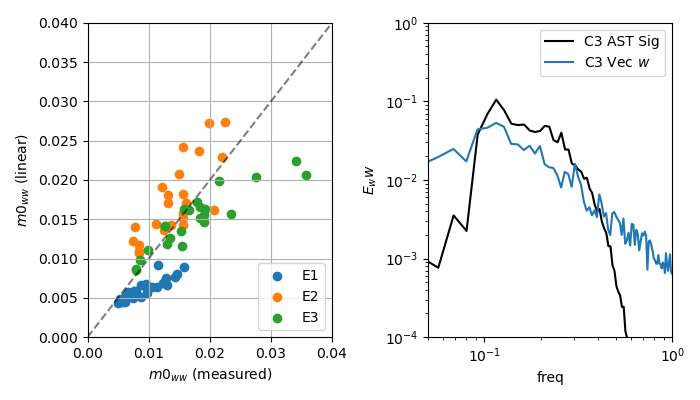

In [527]:
fig, axes = plt.subplots(figsize=(7,4), ncols=2)

axes[0].plot(np.linspace(0, 0.04), np.linspace(0, 0.04), color='k', linestyle='--', alpha=0.5)
axes[0].scatter(c3m0_wm['E1'], c3m0_wl['E1'], label='E1')
axes[0].scatter(c3m0_wm['E2'], c3m0_wl['E2'], label='E2')
axes[0].scatter(c3m0_wm['E3'], c3m0_wl['E3'], label='E3')

axes[0].set_xlim([0, 0.04])
axes[0].set_ylim([0, 0.04])
axes[0].grid()
axes[0].legend(fontsize=10, loc='lower right')
axes[0].set_ylabel(r'$m0_{uu}$ (linear)')
axes[0].set_xlabel(r'$m0_{uu}$ (measured)')

axes[1].plot(spec_ast.freq.values, Euu_lin, color='k', label='C3 AST Sig')
axes[1].plot(spec.freq.values, Euu_vec, color='k', label='C3 AST Sig')

axes[1].set_ylabel(r'$E_uu$')
axes[1].set_xlim([0.05, 1])
axes[1].set_ylim([1e-4, 1])
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend(fontsize=10, loc='upper right')

plt.tight_layout()
plt.show()

In [ ]:
fig, axes = plt.subplots(figsize=(7,4), ncols=2)

# axes[0].plot(np.linspace(0, 0.04), np.linspace(0, 0.04), color='k', linestyle='--', alpha=0.5)
axes[0].scatter(c3m0_um['E1'], c3m0_ul['E1'], label='E1')
axes[0].scatter(c3m0_um['E2'], c3m0_ul['E2'], label='E2')
axes[0].scatter(c3m0_um['E3'], c3m0_ul['E3'], label='E3')

axes[0].set_xlim([0, 0.04])
axes[0].set_ylim([0, 0.04])
axes[0].grid()
axes[0].legend(fontsize=10, loc='lower right')
axes[0].set_ylabel(r'$m0_{ww}$ (linear)')
axes[0].set_xlabel(r'$m0_{ww}$ (measured)')

axes[1].plot(spec_ast.freq.values, Euu_lin, color='k', label='C3 AST Sig')
spec_u.Ezz.plot(ax=axes[1], label=r'C3 Vec $w$')

axes[1].set_ylabel(r'$E_ww$')
axes[1].set_xlim([0.05, 1])
axes[1].set_ylim([1e-4, 1])
axes[1].set_xscale('log')
axes[1].set_yscale('log')
axes[1].legend(fontsize=10, loc='upper right')

plt.tight_layout()
plt.show()

Plot mean circulation around rock for the 3 events.

/tmp/ipykernel_1004468/2560814151.py:21: UserWarning: The following kwargs were not used by contour: 'linewidth'
  ax.contour(dsbat.eastings, dsbat.northings, dsbat.z_utm, vmin=-8.0, vmax=-3.5,


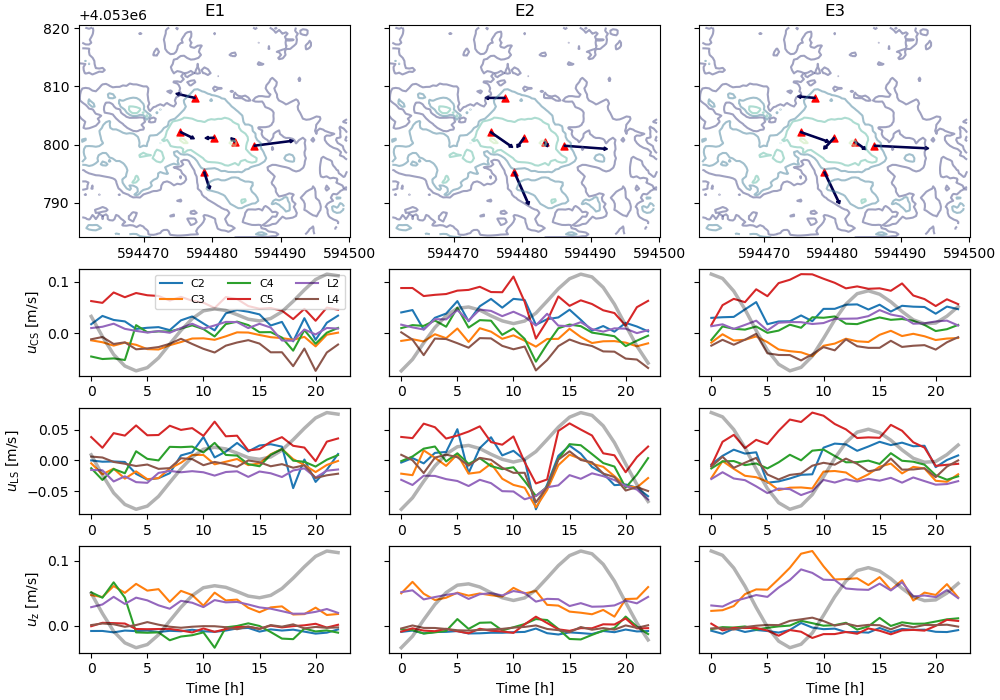

In [508]:
from matplotlib import colors, cm

# From https://stackoverflow.com/questions/73017192/rendering-colors-to-arrows-based-on-an-array-using-matplotlib
V=np.array([[10],[20],[30],[40],[50],[60]])
cmap = plt.cm.seismic
cNorm  = colors.Normalize(vmin=np.min(V), vmax=np.max(V))
scalarMap = cm.ScalarMappable(norm=cNorm,cmap=cmap)

color_list = []        
for idx in range(0,len(V)):
        colorVal = scalarMap.to_rgba(V[idx])
        r,g,b,a = colorVal[0].tolist()
        color_list.append((r,g,b,a))

eks = ['E1', 'E2', 'E3'] # Event strings
# Initialize figure and plot
fig, axes = plt.subplots(figsize=(10,7), ncols=3, nrows=4, constrained_layout=True, sharex='row', sharey='row',
    gridspec_kw={'height_ratios':[2,1,1,1]})
# Iterate over axes (i.e. events) and plot bathymetry
for i,ax in enumerate(axes[0,:]):
    ax.contour(dsbat.eastings, dsbat.northings, dsbat.z_utm, vmin=-8.0, vmax=-3.5,
                cmap=cmocean.cm.deep_r, levels=3, alpha=0.5, linewidth=0.75)
    # Title: event number
    ax.set_title(eks[i])
    # Mean velocity arrows at mooring locations
    s = 25 # Mooring location marker size
    for mid in ['C2', 'C3', 'C4', 'C5', 'L2', 'L4']:
        u = np.nanmean(uem['{}-{}'.format(mid, eks[i])]) # cross-shore vel.
        v = np.nanmean(unm['{}-{}'.format(mid, eks[i])]) # long-shore vel.
        w = np.nanmean(wm['{}-{}'.format(mid, eks[i])]) # vertical vel.
        umag = np.sqrt(u**2 + v**2)
        # Mooring x,y coordinates (UTM)
        xm = dsbat['{}_utm'.format(mid)][0].item()
        ym = dsbat['{}_utm'.format(mid)][1].item()
        fact = 100 # Arrow length factor
        ax.scatter(xm, ym, marker='^', color='r', s=s)
        ax.arrow(xm, ym, dx=u*fact, dy=v*fact, width=0.2, head_length=0.5, 
                fc=color_list[0], ec=color_list[0], length_includes_head=True,)
# Plot 20-min. mean CS velocities per event on second row
for i,ax in enumerate(axes[1,:]):
    for mid in ['C2', 'C3', 'C4', 'C5', 'L2', 'L4']:
        time = np.arange(len(uem['{}-{}'.format(mid, eks[i])])) # Time in hours
        # Mean sea level in background (on second axis)
        if mid == 'C2':
            ax2 = ax.twinx()
            ax2.plot(time, np.array(slm['{}-{}'.format(mid, eks[i])]), alpha=0.3, linewidth=2.5, color='k')
            ax2.yaxis.set_tick_params(labelleft=False)
            ax2.set_yticks([])
        u = np.array(uem['{}-{}'.format(mid, eks[i])]) # cross-shore vel.
        v = np.array(unm['{}-{}'.format(mid, eks[i])]) # long-shore vel.
        umag = np.sqrt(u**2 + v**2)
        ax.plot(time, u, label=mid)
        if i == 0:
            ax.set_ylabel(r'$u_\mathrm{CS}$ [m/s]')
# Plot 20-min. mean LS velocities per event on second row
for i,ax in enumerate(axes[2,:]):
    for mid in ['C2', 'C3', 'C4', 'C5', 'L2', 'L4']:
        time = np.arange(len(uem['{}-{}'.format(mid, eks[i])])) # Time in hours
        if mid == 'C2':
            ax2 = ax.twinx()
            ax2.plot(time, np.array(slm['{}-{}'.format(mid, eks[i])]), alpha=0.3, linewidth=2.5, color='k')
            ax2.yaxis.set_tick_params(labelleft=False)
            ax2.set_yticks([])
        v = np.array(lsm['{}-{}'.format(mid, eks[i])]) # long-shore vel.
        umag = np.sqrt(u**2 + v**2)
        ax.plot(time, v, label=mid)
        if i == 0:
            ax.set_ylabel(r'$u_\mathrm{LS}$ [m/s]')
# Vertical velocities on bottom
for i,ax in enumerate(axes[3,:]):
    for mid in ['C2', 'C3', 'C4', 'C5', 'L2', 'L4']:
        time = np.arange(len(uem['{}-{}'.format(mid, eks[i])])) # Time in hours
        if mid == 'C2':
            ax2 = ax.twinx()
            ax2.plot(time, np.array(slm['{}-{}'.format(mid, eks[i])]), alpha=0.3, linewidth=2.5, color='k')
            ax2.yaxis.set_tick_params(labelleft=False)
            ax2.set_yticks([])
        w = np.array(wm['{}-{}'.format(mid, eks[i])]) # vertical vel.
        ax.plot(time, w, label=mid)
        if i == 0:
            ax.set_ylabel(r'$u_\mathrm{z}$ [m/s]')
        ax.set_xlabel('Time [h]')
axes[1,0].legend(fontsize=8, ncol=3)

plt.show()
# plt.clf()

E1 nu: 0.28, Tp: 9.89
E2 nu: 0.28, Tp: 8.32
E3 nu: 0.30, Tp: 8.95


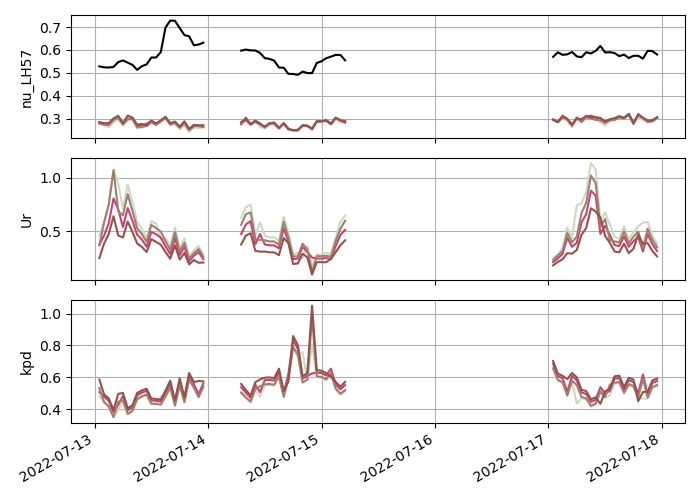

In [281]:
mids = ['C2', 'C3', 'C4', 'C5', ]#'L2', 'L4'] # Mooring IDs
cs = ['#CADBC0', '#C94277', '#A27E6F', '#94524A', '#2F0A28', '#6B717E']
fig, axes = plt.subplots(figsize=(7,5), nrows=3, sharex=True)
for ek in ['E1', 'E2', 'E3']:
    nus = [] # List for averaging bandwidths
    tps = [] # List for averaging peak periods
    for mi, mid in enumerate(mids):
        dsm['{}-{}'.format(mid, ek)].nu_LH57.plot(ax=axes[0], color=cs[mi])
        if mid == 'C3':
            dsm['{}-{}'.format(mid, ek)].nu_AST_C3.plot(ax=axes[0], color='k')
        dsm['{}-{}'.format(mid, ek)].Ur.plot(ax=axes[1], color=cs[mi])
        dsm['{}-{}'.format(mid, ek)].kpd.plot(ax=axes[2], color=cs[mi])
        nus.append(dsm['{}-{}'.format(mid, ek)].nu_LH57.mean().item())
        tps.append(dsm['{}-{}'.format(mid, ek)].Tp_ind.mean().item())
    print('{} nu: {:.2f}, Tp: {:.2f}'.format(ek, np.mean(nus), np.mean(tps)))
axes[0].set_yticks([0.3, 0.4, 0.5, 0.6, 0.7])
for ax in axes:
    ax.set_xlabel(None)
    ax.grid()
plt.tight_layout()
plt.show()
# eta

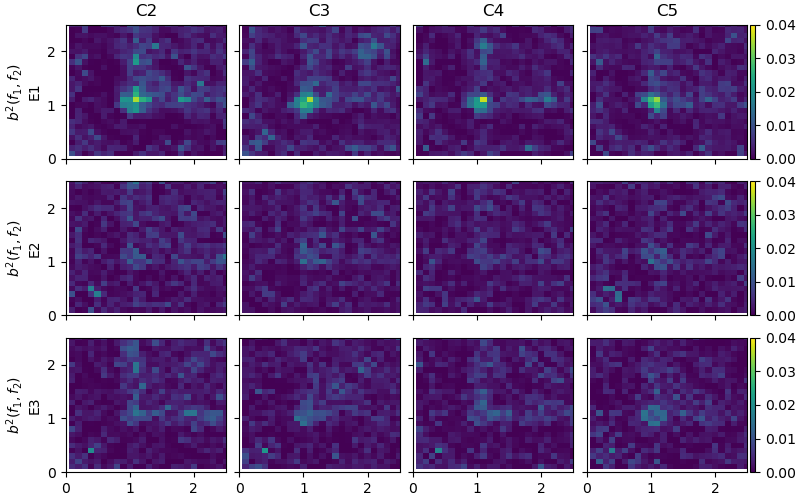

In [415]:
# Plot bicoherence for select times
fig, axes = plt.subplots(figsize=(8,5), ncols=4, nrows=3, sharex=True, sharey=True,
                         constrained_layout=True)
mids = ['C2', 'C3', 'C4', 'C5']
cs = ['red', 'blue', 'gray']
for ei, ek in enumerate(['E1', 'E2', 'E3']):
    for mi, mid in enumerate(mids):
        ax = axes[ei,mi]
        im = (dsbc['{}-{}'.format(mid, ek)]**2).mean(dim='time').plot.pcolormesh(ax=ax, add_colorbar=False,
            vmin=0, vmax=0.04)
        ax.set_xlabel(None)
        if mi == 0:
            ax.set_ylabel(r'$b^2(f_1, f_2)$'+'\n{}'.format(ek))
        else:
            ax.set_ylabel(None)
        if ei == 0:
            ax.set_title(mid)
        ax.set_xlim([0,2.5])
        ax.set_ylim([0,2.5])

        if mi == 3:
            cax = ax.inset_axes([1.02, 0.0, 0.03, 1.0])
            fig.colorbar(im, ax=ax, cax=cax)

# plt.tight_layout()
plt.show()

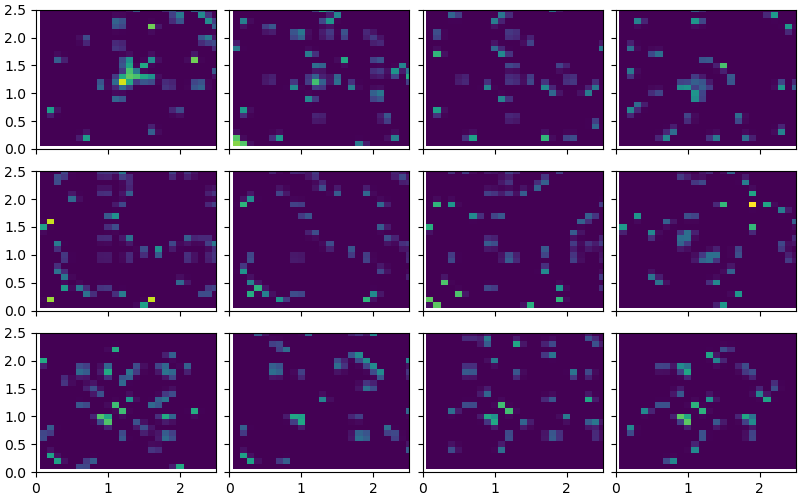

In [356]:
# Plot bicoherence for select times
fig, axes = plt.subplots(figsize=(8,5), ncols=4, nrows=3, sharex=True, sharey=True,
                         constrained_layout=True)
mids = ['C2', 'C3', 'C4', 'C5']
cs = ['red', 'blue', 'gray']
for ei, ek in enumerate(['E1', 'E2', 'E3']):
    for mi, mid in enumerate(mids):
        ax = axes[ei,mi]
        if ek == 'E1':
            (dsbc['{}-{}'.format(mid, ek)]**2).sel(time='2022-07-13 04:00:00').plot.pcolormesh(
                ax=ax, add_colorbar=False, vmin=0, vmax=0.1)
        elif ek == 'E2':
            (dsbc['{}-{}'.format(mid, ek)]**2).sel(time='2022-07-14 09:00:00').plot.pcolormesh(
                ax=ax, add_colorbar=False, vmin=0, vmax=0.1)
        elif ek == 'E3':
            (dsbc['{}-{}'.format(mid, ek)]**2).sel(time='2022-07-17 09:00:00').plot.pcolormesh(
                ax=ax, add_colorbar=False, vmin=0, vmax=0.1)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_title(None)
        ax.set_xlim([0,2.5])
        ax.set_ylim([0,2.5])

# plt.tight_layout()
plt.show()

In [342]:
dsbc['{}-{}'.format(mid, ek)].time

<xarray.DataArray 'time' (time: 23)>
array(['2022-07-12T00:00:00.000000000', '2022-07-12T00:00:00.000000000',
       '2022-07-12T00:00:00.000000000', '2022-07-12T00:00:00.000000000',
       '2022-07-12T00:00:00.000000000', '2022-07-12T00:00:00.000000000',
       '2022-07-12T00:00:00.000000000', '2022-07-12T00:00:00.000000000',
       '2022-07-12T00:00:00.000000000', '2022-07-12T00:00:00.000000000',
       '2022-07-12T00:00:00.000000000', '2022-07-12T00:00:00.000000000',
       '2022-07-12T00:00:00.000000000', '2022-07-12T00:00:00.000000000',
       '2022-07-12T00:00:00.000000000', '2022-07-12T00:00:00.000000000',
       '2022-07-12T00:00:00.000000000', '2022-07-12T00:00:00.000000000',
       '2022-07-12T00:00:00.000000000', '2022-07-12T00:00:00.000000000',
       '2022-07-12T00:00:00.000000000', '2022-07-12T00:00:00.000000000',
       '2022-07-12T00:00:00.000000000'], dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2022-07-12 2022-07-12 ... 2022-07-12

Mean bicoh: 0.01
Mean bicoh: 0.01
Mean bicoh: 0.01
Mean bicoh: 0.01
Mean bicoh: 0.00
Mean bicoh: 0.00
Mean bicoh: 0.00
Mean bicoh: 0.01
Mean bicoh: 0.01
Mean bicoh: 0.01
Mean bicoh: 0.00
Mean bicoh: 0.01


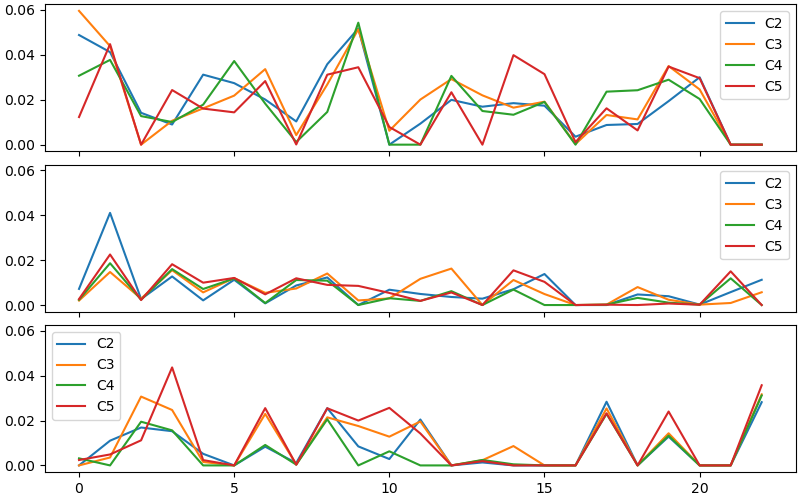

In [420]:
# Plot bicoherence at peak frequency
fig, axes = plt.subplots(figsize=(8,5), nrows=3, sharex=True, sharey=True,
                         constrained_layout=True)
mids = ['C2', 'C3', 'C4', 'C5']
cs = ['#CADBC0', '#C94277', '#A27E6F', '#94524A', '#2F0A28', '#6B717E']
for ei, ek in enumerate(['E1', 'E2', 'E3']):
    for mi, mid in enumerate(mids):
        ax = axes[ei]
        ax.plot((dsbc['{}-{}'.format(mid, ek)].sel(f1n=slice(0.9, 1.1), f2n=slice(0.9, 1.1))**2).mean(
            dim=['f1n', 'f2n']), label=mid)
        print('Mean bicoh: {:.2f}'.format((dsbc['{}-{}'.format(mid, ek)].sel(
            f1n=slice(0.75, 1.25), f2n=slice(0.75, 1.25))**2).mean(
                dim=['f1n', 'f2n']).mean()))
        ax.set_xlabel(None)
        ax.set_ylabel(None)
        ax.set_title(None)
    ax.legend()

# plt.tight_layout()
plt.show()

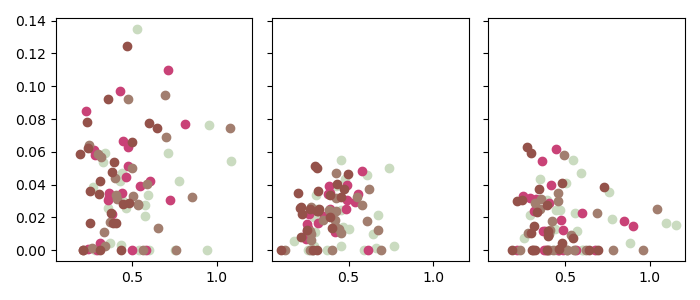

In [338]:
fig, axes = plt.subplots(figsize=(7,3), ncols=3, sharex=True, sharey=True,
                         constrained_layout=True)
cs = ['#CADBC0', '#C94277', '#A27E6F', '#94524A', '#2F0A28', '#6B717E']
for ei, ek in enumerate(['E1', 'E2', 'E3']):
    for mi,mid in enumerate(mids):
        y = dsbc['{}-{}'.format(mid, ek)].sel(f1n=slice(0.75, 1.25), f2n=slice(0.75, 1.25)).mean(
                    dim=['f1n', 'f2n'])
        x = dsm['{}-{}'.format(mid, ek)].Ur.values
        axes[ei].scatter(x, y, c=cs[mi])
plt.tight_layout()
plt.show()

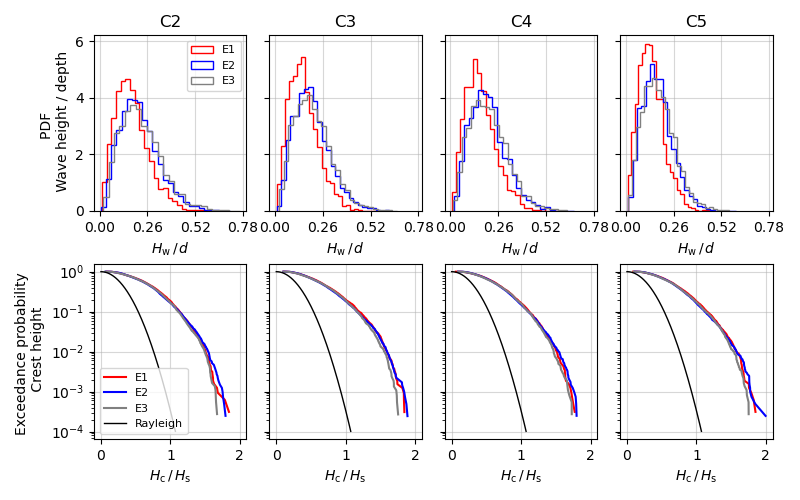

In [425]:
fig, axes = plt.subplots(figsize=(8,5), ncols=4, nrows=2, sharex='row', sharey='row')
mids = ['C2', 'C3', 'C4', 'C5']
cs = ['red', 'blue', 'gray']
for ei, ek in enumerate(['E1', 'E2', 'E3']):
    for mi, mid in enumerate(mids):
        ax = axes[1,mi]
        # Get xy axes for wave height distributions
        x = dzcs['{}-{}'.format(mid, ek)].Hwun.values # Norm. wave heights
        # Get probabilities for y axis
        y, std = rpzc.exceedance_prob(x)
        # Plot distribution in semilogy
        ax.semilogy(np.sort(x), y, label=ek, color=cs[ei])
        ax.grid(alpha=0.5)
        ax.set_xlabel(r'$H_\mathrm{c} \, / \, H_\mathrm{s}$')
#         # Plot Rayleigh distribution (just once)
        if ei == 2:
            xrr = np.linspace(0, 2.5, 500)
            peta4 = np.exp(-8*(xrr**2)) # Crest heights
            # peta4 = np.exp(-2*(xrr**2)) # Wave heights
            ind = np.where(peta4 >= 0.0001) # (only down to 10^-5)
            ax.semilogy(xrr[ind], peta4[ind], color='k', linestyle='-', label='Rayleigh',
                        linewidth=1)
        # Scatter plots of wave heights / depth on second row
        hw = dzcs['{}-{}'.format(mid, ek)].Hw.values
        d = dzcs['{}-{}'.format(mid, ek)].depth.values
        hwd = hw / d
        # print('Max Hw/d = {:.2f}'.format(np.max(hwd)))
        axes[0,mi].hist(hwd, bins=25, color=cs[ei], density=True, histtype='step', label=ek)
        axes[0,mi].set_title(mid)
        axes[0,mi].set_xticks([0, 0.26, 0.52, 0.78])
        axes[0,mi].grid(alpha=0.5)
        axes[0,mi].set_xlabel(r'$H_\mathrm{w} \, / \, d$')

axes[1,0].legend(fontsize=8)
axes[0,0].legend(fontsize=8)
axes[0,0].set_ylabel('PDF \n Wave height / depth')
axes[1,0].set_ylabel('Exceedance probability \n Crest height')
plt.tight_layout()
plt.subplots_adjust(wspace=0.15, hspace=0.3)
plt.show()